# Face Detection

In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import numpy as np
import os
import warnings
import logging
import scipy.io

%matplotlib inline

is_testing = False

## Download data

In [43]:
data_dir       = "/content"     # If possible set an absolute path to avoid complications

train_dir      = f"{data_dir}/WIDER_train"
val_dir        = f"{data_dir}/WIDER_val"
test_dir       = f"{data_dir}/WIDER_test"
face_split_dir = f"{data_dir}/wider_face_split"

if not os.path.exists(train_dir):
    ! wget -P "$train_dir".zip https://abcdapp.net/datasets/wider/WIDER_train.zip
    ! unzip -q "$train_dir".zip/*
if not os.path.exists(val_dir):
    ! wget -P "$val_dir".zip https://abcdapp.net/datasets/wider/WIDER_val.zip
    ! unzip -q "$val_dir".zip/*
if is_testing and not os.path.exists(test_dir):
    ! wget -P "$test_dir".zip https://abcdapp.net/datasets/wider/WIDER_test.zip
    ! unzip -q "$test_dir".zip/*
if not os.path.exists(face_split_dir):
    ! wget -P "$face_split_dir".zip https://abcdapp.net/datasets/wider/wider_face_split.zip
    ! unzip -q "$face_split_dir".zip/*
print("Dataset is ready to use.")

Dataset is ready to use.


## Load data

In [0]:
# Helper class to train/validation/test data
# Found it from http://mmlab.ie.cuhk.edu.hk/projects/WIDERFace/

class WIDERFACEDataset():
    def __init__(self, data_dir, label_mat_file, use_difficult=False, return_difficult=False, 
                 exclude_file_list=None, logger=None):
        self.data_dir = data_dir
        self.label_mat_file = label_mat_file
        self.use_difficult = use_difficult
        self.return_difficult = return_difficult
        
        self.logger = logger #for 
        # list up files
        mat = scipy.io.loadmat(self.label_mat_file)
        self.ids = []
        self.bboxs = {}
        self.labels = {}
        self.difficult = {}
        for i in range(len(mat['event_list'])):
            event = mat['event_list'][i,0][0]
            for j in range(len(mat['file_list'][i,0])):
                file = mat['file_list'][i,0][j,0][0]
                filename = "{}.jpg".format(file)
                filepath = os.path.join(data_dir, 'images', event, filename)
                if exclude_file_list != None and filename in exclude_file_list:
                    continue
                # bounding boxes and labels of the picture file
                bboxs = mat['face_bbx_list'][i,0][j,0]
                # convert from (x, y, w, h) to (y1, x1, y2, x2)
                swapped_bbxs = bboxs[:, [1,0,3,2]] #  (y,x,h,w)
                swapped_bbxs[:,2:4] = swapped_bbxs[:,2:4] + swapped_bbxs[:,0:2]
                
                invalid_labels = mat['invalid_label_list'][i,0][j,0].ravel()
                pose_labels = mat['pose_label_list'][i,0][j,0].ravel()
                illum_labels = mat['illumination_label_list'][i,0][j,0].ravel()
                occlusion_labels = mat['occlusion_label_list'][i,0][j,0].ravel()
                blur_labels = mat['blur_label_list'][i,0][j,0].ravel()
                expression_labels = mat['expression_label_list'][i,0][j,0].ravel()
                
                self.ids.append(filepath)
                self.bboxs[filepath] = swapped_bbxs.astype(np.float32)
                self.labels[filepath] = np.zeros(len(bboxs), dtype=np.int32) #dummy, always 0
                self.difficult[filepath] = invalid_labels

    def get_example(self, i):
        """Returns the i-th example.
        Returns a color image and bounding boxes. The image is in CHW format.
        The returned image is RGB.
        Args:
            i (int): The index of the example.
        Returns:
            tuple of an image and bounding boxes
        """
        id_ = self.ids[i]
        bbox = self.bboxs[id_].astype(np.float32)
        label = self.labels[id_].astype(np.int32)
        difficult = self.difficult[id_].astype(np.bool)
        if not self.use_difficult:
            bbox = bbox[np.where(difficult==False)]
            label = label[np.where(difficult==False)]
            difficult = difficult[np.where(difficult==False)]

        # Load a image
        img = mpimg.imread(id_)
        if self.logger:
            self.logger.debug(id_)
        if self.return_difficult:
            return img, bbox, label, difficult
        return img, bbox, label, id_

In [59]:
train_data = WIDERFACEDataset(train_dir, face_split_dir + "/wider_face_train.mat")
print("Training Size:", len(train_data.labels))

val_data = WIDERFACEDataset(val_dir, face_split_dir + "/wider_face_val.mat")
print("Validation Size:", len(val_data.labels))

Training Size: 12880
Validation Size: 3226


### Show a sample data

Image Id: /content/WIDER_train/images/0--Parade/0_Parade_marchingband_1_117.jpg
Bounding Box: [[359.  69. 395. 119.]
 [382. 227. 425. 283.]
 [305. 296. 331. 340.]
 [280. 353. 316. 393.]
 [377. 885. 418. 948.]
 [391. 819. 434. 853.]
 [342. 727. 373. 764.]
 [246. 598. 275. 631.]
 [308. 740. 341. 785.]]
Labels [0 0 0 0 0 0 0 0 0]


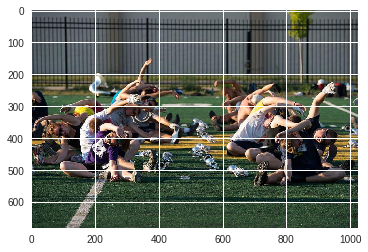

In [60]:
img, bbox, label, id = train_data.get_example(3)

print("Image Id:", id)

print("Bounding Box:", bbox) # or use train_data.labels[id]

print("Labels", label) # or use train_data..labels[id])

plt.imshow(img)
plt.show()